<a href="https://colab.research.google.com/github/VaishnaviDevi08/DL-ASSIGNMENT1/blob/main/dl_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10, Validation Loss: 1.0342, Validation Accuracy: 0.6736
Epoch 2/10, Validation Loss: 0.5813, Validation Accuracy: 0.8056
Epoch 3/10, Validation Loss: 0.4487, Validation Accuracy: 0.8333
Epoch 4/10, Validation Loss: 0.3651, Validation Accuracy: 0.8681
Epoch 5/10, Validation Loss: 0.3100, Validation Accuracy: 0.8889
Epoch 6/10, Validation Loss: 0.2739, Validation Accuracy: 0.8958
Epoch 7/10, Validation Loss: 0.2441, Validation Accuracy: 0.9028
Epoch 8/10, Validation Loss: 0.2218, Validation Accuracy: 0.9236
Epoch 9/10, Validation Loss: 0.2033, Validation Accuracy: 0.9375
Epoch 10/10, Validation Loss: 0.1889, Validation Accuracy: 0.9375
Test Accuracy: 0.9556


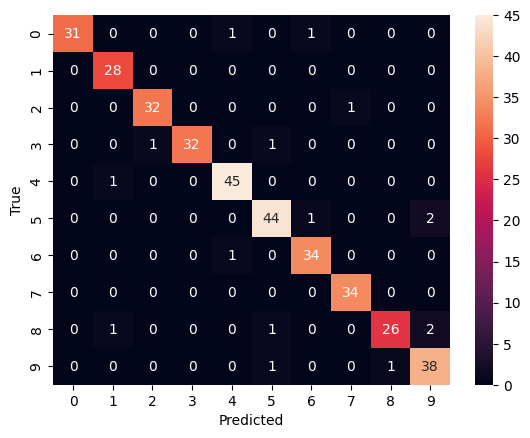

In [ ]:
#DL ASSIGNMENT1
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Derivative of activation functions
def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Loss functions
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / m

def mean_squared_error(y_true, y_pred):
    m = y_true.shape[0]
    return np.sum((y_true - y_pred) ** 2) / m

# Neural Network Class
class FeedforwardNeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', weight_init='xavier'):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.weights = []
        self.biases = []
        self.weight_init = weight_init
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(len(self.layer_sizes) - 1):
            if self.weight_init == 'xavier':
                limit = np.sqrt(6 / (self.layer_sizes[i] + self.layer_sizes[i + 1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layer_sizes[i], self.layer_sizes[i + 1])))
            else:
                self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, self.layer_sizes[i + 1])))

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            if i == len(self.weights) - 1:
                a = softmax(z)  # Output layer
            else:
                a = relu(z) if self.activation == 'relu' else sigmoid(z)
            self.activations.append(a)
        return self.activations[-1]

    def backward(self, X, y, learning_rate, optimizer='sgd', momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        m = X.shape[0]
        gradients = []
        delta = self.activations[-1] - y  # Output layer error
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            gradients.append((dw, db))
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * (relu_derivative(self.activations[i]) if self.activation == 'relu' else sigmoid_derivative(self.activations[i]))

        # Update weights and biases
        for i in range(len(self.weights)):
            if optimizer == 'sgd':
                self.weights[i] -= learning_rate * gradients[-(i + 1)][0]
                self.biases[i] -= learning_rate * gradients[-(i + 1)][1]
            elif optimizer == 'momentum':
                if not hasattr(self, 'velocity'):
                    self.velocity = [np.zeros_like(w) for w in self.weights]
                self.velocity[i] = momentum * self.velocity[i] - learning_rate * gradients[-(i + 1)][0]
                self.weights[i] += self.velocity[i]
                self.biases[i] -= learning_rate * gradients[-(i + 1)][1]
            elif optimizer == 'adam':
                if not hasattr(self, 'm'):
                    self.m = [np.zeros_like(w) for w in self.weights]
                    self.v = [np.zeros_like(w) for w in self.weights]
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * gradients[-(i + 1)][0]
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (gradients[-(i + 1)][0] ** 2)
                m_hat = self.m[i] / (1 - beta1 ** (i + 1))
                v_hat = self.v[i] / (1 - beta2 ** (i + 1))
                self.weights[i] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
                self.biases[i] -= learning_rate * gradients[-(i + 1)][1]

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, learning_rate=0.001, optimizer='sgd', weight_decay=0):
        for epoch in range(epochs):
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate, optimizer)
                if weight_decay > 0:
                    for w in self.weights:
                        w -= learning_rate * weight_decay * w

            y_val_pred = self.forward(X_val)
            val_loss = cross_entropy_loss(y_val, y_val_pred)
            val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    def evaluate(self, X_test, y_test):
        y_pred = self.forward(X_test)
        test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
        print(f"Test Accuracy: {test_acc:.4f}")
        return y_pred

# Example usage
if __name__ == "__main__":
    # Load and preprocess dataset (replace with Caltech-256 or MNIST)
    from sklearn.datasets import load_digits

    data = load_digits()
    X = data.data
    y = data.target.reshape(-1, 1)
    y = OneHotEncoder(sparse_output=False).fit_transform(y)  # Fix: Use sparse_output instead of sparse

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Define and train the model
    model = FeedforwardNeuralNetwork(layer_sizes=[X.shape[1], 64, 32, y.shape[1]], activation='relu', weight_init='xavier')
    model.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=32, learning_rate=0.001, optimizer='adam', weight_decay=0.0005)

    # Evaluate the model
    y_pred = model.evaluate(X_test, y_test)

    # Plot confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
!git clone https://github.com/VaishnaviDevi08/DL-ASSIGNMENT1.git
